In [2]:
from qutip import *
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt




class iswap():
    '''
    **params
    wcShape=lambda t:f(t)
    w   GateLen TStep   yita    amp
    g   T1      T2      T2_echo
    w=[w0,w1]
    g=[g12,g2c,g1c]
    
    GHz for w_i and MHz for g_i,yita_i ,ns for T_i,GateLen
    wcShape with amp=1 and will cut in [-0.5,0.5]
    '''
    def __init__(self,**params) -> None:
        
        self.parameters={
        
        'wcShape':lambda t: 1,
        'L':50,
        'TStep':100,
        #######for 2021
        # 'g':[20,71.5,72.5],
        # 'g':[5,30.6,31.1],
        # 'w':[4.16,4,5.45],
        #######for 2018
        'g':[5.2,35,33.8],
        #g1c,g2c多sqrt(2pi)，下面glist乘了2pi，后面乘sqrt（w）时又乘sqrt（2pi）
         
        # 'g':[5.2,81.7,78.9],
        'w':[4,4,5.45],
        #g1c,g2c*=sqrt(wc)
        #wc_off suppose to be 5.426
        #######for test
        # 'g':[0,0,0],
        
        'yita':[-220,-210,-90],
        'T1':[60,30,10],
        'T2':[66,5,1],
        'T2_echo':[103,16,6],
        'amp':0,
        'n':3
        }
        self.parameters.update(params)
        self.wcShape,self.L,self.TStep,self.g,self.w,self.yita,self.T1,self.T2,\
        self.T2_echo,self.amp,self.n=self.parameters.values()
        self.w=[i*2*np.pi for i in self.w]
        self.yita=[i*0.001*2*np.pi for i in self.yita]
        self.g=[i*0.001*2*np.pi for i in self.g]
        self.amp=2*np.pi*self.amp
        self.T1=[i*1000 for i in self.T1]
        self.T2=[i*1000 for i in self.T2]
        self.T2_echo=[i*1000 for i in self.T2_echo]
        self.tlist=np.linspace(-self.L/2,self.L/2,self.TStep)
        if self.amp!=0:
            self.w[2]=0
        self.wt=lambda t,args : \
            self.wcShape(t/self.L)*self.amp if self.L/2>=t>=-self.L/2 else 0
        global n
        n=self.n


    @property
    def get_param(self):
        return self.parameters
    
    def paramSet(self,dict={},**params):
        '''
        label=value
        label:varible'''
        self.parameters.update(dict)
        self.parameters.update(params)
        self.wcShape,self.L,self.TStep,self.g,self.w,self.yita,self.T1,self.T2,\
        self.T2_echo,self.amp,self.n=self.parameters.values()
        self.w=[i*2*np.pi for i in self.w]
        self.yita=[i*0.001*2*np.pi for i in self.yita]
        self.g=[i*0.001*2*np.pi for i in self.g]
        self.amp=2*np.pi*self.amp
        self.T1=[i*1000 for i in self.T1]
        self.T2=[i*1000 for i in self.T2]
        self.T2_echo=[i*1000 for i in self.T2_echo]
        self.tlist=np.linspace(-self.L/2,self.L/2,self.TStep)
        if self.amp!=0:
            self.w[2]=0
        self.wt=lambda t,args : \
            self.wcShape(t/self.L)*self.amp if self.L/2>=t>=-self.L/2 else 0
        global n
        n=self.n
    ########################################
    # Hermitian
    @property
    def H(self):
        a=destroy(n)
        ad=a.dag()
        v=ad-a
        hi=[0]*3
        h=[0]*3
        G=[0]*3
        H0=0
        I=qeye(n)

        for i in [0,1,2]:
            hi[i]=self.w[i]*ad*a+self.yita[i]/2*ad*ad*a*a
        
        h[0]=tensor(hi[0],I,I)
        h[1]=tensor(I,hi[1],I)
        h[2]=tensor(I,I,hi[2])
        hc=tensor(I,I,ad*a)

        G[0]=self.g[0]*tensor(v,v,I)
        ######## for 2021
        # G[1]=self.g[1]*tensor(qeye(n),v,v)
        # G[2]=self.g[2]*tensor(v,qeye(n),v)
        ######## for 2018
        G[1]=0*self.g[1]*tensor(I,v,v)
        G[2]=0*self.g[2]*tensor(v,I,v)
        sqrtwt=lambda t,args : np.sqrt(self.wt(t,args))/np.sqrt(2*np.pi)
        sg=self.g[1]*tensor(I,v,v)+self.g[2]*tensor(v,I,v)
        ########

        for i in [0,1,2]:
            H0+=h[i]+G[i]

        ### 2018
        H=[H0,[hc,self.wt],[sg,sqrtwt]]
        ### 2021
        # H=[H0,[hc,self.wt]]
        return H
    
    @property
    def udag(self):
        '''u=exp(-i*sh),
        udag=exp(i*sh),
        psid=udag*psi0
        OperDressed=udag*O*u
        wc=wc(t=0)
        '''
        wc=self.wt(0,0)
        if wc-self.w[0]==0:
            wc=self.w[0]+0.1
        a=destroy(n)
        ad=a.dag()
        I=qeye(n)
        h= (self.g[2]/(wc-self.w[0])*(tensor(ad,I,a)-tensor(a,I,ad))-\
            self.g[2]/(wc+self.w[0])*(tensor(ad,I,ad)-tensor(a,I,a))+\
            self.g[1]/(wc-self.w[1])*(tensor(I,ad,a)-tensor(I,a,ad))-\
            self.g[1]/(wc+self.w[1])*(tensor(I,ad,ad)-tensor(I,a,a)))*\
            1j*np.sqrt(wc)/np.sqrt(2*np.pi)
        hes=h.eigenstates()
        # ketd=hes[1]
        # rhod=[p*p.dag() for p in ketd]
        udag=0
        for i in range(n**3):
            udag+=np.exp(1j*hes[0][i])*hes[1][i]*hes[1][i].dag()
        # psi=udag*psi0
        return udag
    

    ################################

    def GateProcess(self,result,p):
        fig, ax = plt.subplots()
        ax.plot(result.times ,
                np.transpose([result.expect[p]]))
                #  np.transpose([result.expect[3],result.expect[4],result.expect[5]]))
        ax.set_xlabel('t/ns')
        ax.set_ylabel('Population')
        ax.legend(('P'))
        plt.show()
        b=qutip.Bloch()
        b.add_points([result.expect[8],result.expect[9],result.expect[10]],'l')
        b.show()
        return
    
    def run(self,psi0=None):
        '''
        psi0=100,undressed
        sx1=10,01+01,10,
        sy1=-j01,10+j10,01
        sz1=01,01-10,10
        '''
        if psi0==None:
            psi0=tensor(basis(self.n,1),basis(self.n,0),basis(self.n,0))
        
        # udag=self.udag
        psi0=self.udag*psi0

        ket000=tensor(basis(n,0),basis(n,0),basis(n,0))
        ket100=tensor(basis(n,1),basis(n,0),basis(n,0))
        ket010=tensor(basis(n,0),basis(n,1),basis(n,0))
        ket001=tensor(basis(n,0),basis(n,0),basis(n,1))
        ket110=tensor(basis(n,1),basis(n,1),basis(n,0))
        ket011=tensor(basis(n,0),basis(n,1),basis(n,1))
        ket101=tensor(basis(n,1),basis(n,0),basis(n,1))
        ket111=tensor(basis(n,1),basis(n,1),basis(n,1))
        if n>2:
            ket200=tensor(basis(n,2),basis(n,0),basis(n,0))
        else:
            ket200=tensor(basis(n,0),basis(n,0),basis(n,0))

        sx1=ket100*ket010.dag()+ket010*ket100.dag()
        sz1=ket100*ket100.dag()-ket010*ket010.dag()
        sy1=-1j*ket100*ket010.dag()+1j*ket010*ket100.dag()
        p000=ket000*ket000.dag()
        p100=ket100*ket100.dag()
        p010=ket010*ket010.dag()
        p001=ket001*ket001.dag()
        p110=ket110*ket110.dag()
        p011=ket011*ket011.dag()
        p101=ket101*ket101.dag()
        p111=ket111*ket111.dag()
        p200=ket200*ket200.dag()
        e_ops=[p000,p100,p010,p001,p110,p011,p101,p111,sx1,sy1,sz1,p200]
        e_ops=[self.udag*o*self.udag.dag() for o in e_ops]


        result = sesolve(self.H, psi0, self.tlist, e_ops=e_ops,
                         options=Options(store_final_state=1))
        result.FS=result.final_state
        result.FinVal=expect(e_ops,result.FS)

        result.L=self.L#+delay
        def _plt(p=2):
            return self.GateProcess(result,p)
        result.plot=_plt
        #result.times = np.linspace(t0-L/2, t0+L/2, Tstep)
        return result
    
    def _plot(self,x,y,xlabel='param/unit',ylabel='Population'):
        fig, ax = plt.subplots()
        ax.plot(x,y)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        # ax.legend(('P110','P010','P110'))
        plt.show()

    def scan(self,dims=1,tar=1,*param):
        '''
        timecost~~Pstep*Tstep/100
        target:
        0:p000
        1:p100
        2:0010
        3:p001
        4:p110
        5:p011
        6:p101
        7:p111
        8:sx1
        9:sy1
        10:sz1
        param:
        p1=[l,s,s,s],p2=[l,s,s,s] X
        ['label1',start,stop,step],['l',s,s,s] √
        '''
        class output:
            pass
        if dims==1:
            label=param[0][0]
            start=param[0][1]
            stop=param[0][2]
            step=param[0][3]
            z=list(np.empty([step]))
            plist=np.linspace(start,stop,step)
            i=0
            for p in plist:
                self.paramSet({label:p})
                z[i]=np.transpose(self.run().expect[:])
                i+=1
            z=np.transpose(z)
            output.z=z
            # output.extent=[start1,stop1,start2,stop2],
            # output.aspect=(stop1-start1)/(stop2-start2)
            plt.imshow(z[tar],extent=[start,stop,self.tlist[-1],self.tlist[0]],
                       aspect=(stop-start)/(self.tlist[-1]-self.tlist[0]))
            plt.colorbar()
            plt.show()
            # output.value=z
            # output.plist=plist
            # output.plot=self._plot(plist,z[tar],'wc','p')
            return output
        else:
            label1=param[0][0]
            start1=param[0][1]
            stop1=param[0][2]
            step1=param[0][3]
            label2=param[1][0]
            start2=param[1][1]
            stop2=param[1][2]
            step2=param[1][3]
            z=list(np.empty([step1,step2]))
            list1=np.linspace(start1,stop1,step1)
            list2=np.linspace(start2,stop2,step2)            
            i,j=0,0
            for p1 in list1:
                for p2 in list2:
                    self.paramSet({label1:p1,label2:p2})
                    z[j][i]=self.run().FinVal[tar]
                    i+=1
                i=0
                j+=1
            
            z=np.transpose(z)
            output.z=z
            output.extent=[start1,stop1,start2,stop2],
            output.aspect=(stop1-start1)/(stop2-start2)
            plt.imshow(z,extent=[start1,stop1,start2,stop2],
                       aspect=(stop1-start1)/(stop2-start2))
            plt.colorbar()
            plt.show()
            #output.value=z
            #output.plot=self._plot(plist,z[3],'wc','p')
            return output



    # h0=tensor()

c:\Users\1163080609\anaconda3\Lib\site-packages\qutip\__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


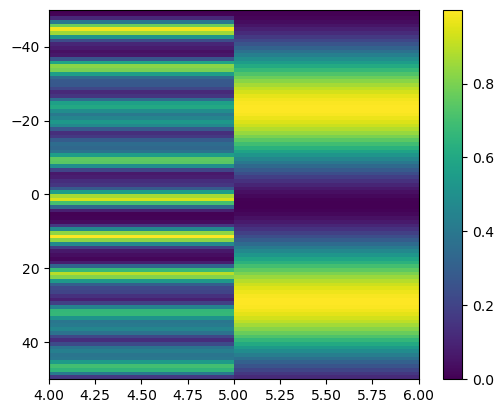

In [3]:
b=iswap(TStep=100,L=100,n=2,amp=5.45)#wcShape=lambda t :5.8,GateLen=300,TStep=1000)
# b.w[0]*N+b.yita[0]/2*ad[i]
# b.H
# b.g
# b.L
# b.udag
s=b.scan(1,2,['amp',4,6,2],['L',1,100,5])
# psi1=(tensor(basis(n,1),basis(n,0),basis(n,0))+0j*tensor(basis(n,0),basis(n,1),basis(n,0))).unit()
# b.run(psi1).plot(1)

In [ ]:
吧。

Population未保留相位信息，bloch的圆周角保留了相位信息

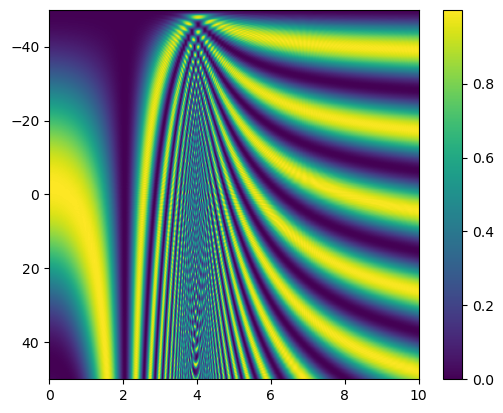

In [116]:
# b=iswap(TStep=300,L=100,n=3,amp=4.5)#wcShape=lambda t :5.8,GateLen=300,TStep=1000)
# b.w[0]*N+b.yita[0]/2*ad[i]
# b.H[0]
# b.L
# s=b.scan(1,2,['amp',0,10,500],['L',1,100,5])
# psi1=(tensor(basis(n,1),basis(n,0),basis(n,0))+0j*tensor(basis(n,0),basis(n,1),basis(n,0))).unit()
# b.run(psi1).plot(2)

In [ ]:
# plt.imshow(s.z[1])#,extent=[start1,stop1,start2,stop2],
#                     #    cmap=cm.gray,aspect=(stop1-start1)/(stop2-start2))
# plt.colorbar()
# plt.show()
b.H.shape